# Stage I GAN

# Importing Libraries

In [0]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from keras.utils import np_utils, to_categorical

# Loading of Dataset

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
import h5py 
hf = h5py.File('drive/My Drive/csci566/deepfashion.hdf5','r+')   
imgs = np.array(hf['images'].value)
one_hot_labels = np.array(hf['labels'].value)
labels = one_hot_labels

RuntimeError: ignored

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 193, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Thu Dec  5 06:48:33 2019
, filename = 'drive/My Drive/csci566/deepfashion.hdf5', file descriptor = 76, errno = 107, error message = 'Transport endpoint is not connected', buf = 0x6dff058, total write size = 96, bytes this sub-write = 96, bytes actually written = 18446744073709551615, offset = 0)


In [18]:
imgs = imgs[:5000, :, :, :]
labels = labels[:5000]

print(imgs.shape)
print(labels.shape)

(5000, 128, 128, 3)
(5000, 25)


In [19]:
X_train, y_train = imgs, labels
NUM_ATTRIBUTES = labels.shape[1]

print("Number of attributes:", NUM_ATTRIBUTES)

Number of attributes: 25


In [0]:
# from skimage.transform import rescale
# X_train_rescaled = np.zeros(shape = (X_train.shape[0], 64, 64, 3))
# for i in range(X_train.shape[0]):
#   X_train_rescaled[i] = rescale(X_train[i], 0.5, anti_aliasing=False)

# print(X_train_rescaled.shape)


import cv2

rescaled = []

for i, img in enumerate(X_train):
    img = img.astype('float32')
    img = cv2.resize(img, (64, 64))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rescaled.append(img)

X_train = np.array(rescaled)

(5000, 64, 64, 3)
0.0 1.0000002


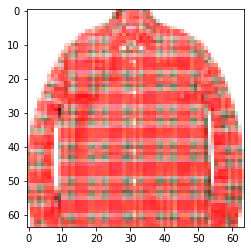

In [21]:
print(X_train.shape)
print(np.amin(X_train), np.amax(X_train))

plt.imshow(X_train[0], interpolation='nearest')
plt.show()

# Model Creation

In [0]:
def build_stage1_generator():

    input_layer = Input(shape=(100,))
    labels = Input(shape=(NUM_ATTRIBUTES,))

    gen_input = Concatenate(axis=1)([input_layer, labels])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, labels], outputs=[x])
    return stage1_gen


In [0]:
def build_stage1_discriminator():

    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(x)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)

    labels = Input(shape=(NUM_ATTRIBUTES,))
    merged_input = concatenate([x2, labels])
    
    x2 = Dense(1)(merged_input)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, labels], outputs=[x2])
    return stage1_dis

In [0]:
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(100,))
    labels = Input(shape=(NUM_ATTRIBUTES,))

    x = gen_model([input_layer, labels])

    dis_model.trainable = False
    valid = dis_model([x, labels])

    model = Model(inputs=[input_layer, labels], outputs=[valid])
    return model

# Defining Loss

In [0]:
def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [0]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

# Setup PyDrive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Main File

In [0]:
if __name__ == '__main__':
    image_size = 64
    batch_size = 64
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 100
    condition_dim = 128
    
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    stage1_dis = build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    adversarial_model.compile(loss=['binary_crossentropy'], loss_weights=[1],
                              optimizer=gen_optimizer, metrics=None)

    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))
            
            """
            Train the discriminator network
            """
            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # Generate fake images
            fake_images = stage1_gen.predict([z_noise, label_batch], verbose=3)

            dis_loss_real = stage1_dis.train_on_batch([image_batch, label_batch],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, label_batch],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)],label_batch[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network 
            """
            g_loss = adversarial_model.train_on_batch([z_noise, label_batch],[K.ones((batch_size, 1)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        
        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            z_noise2 = np.random.normal(0, 1, size=(NUM_ATTRIBUTES, z_dim))
            labels2 = to_categorical(np.arange(0, NUM_ATTRIBUTES).reshape(-1, 1), NUM_ATTRIBUTES)
            fake_images = stage1_gen.predict_on_batch([z_noise2, labels2])

            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "results2/gen_{}_{}.png".format(epoch, i))

    # Save models
    stage1_gen.save_weights("stage1_gen.h5")
    stage1_dis.save_weights("stage1_dis.h5")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch is: 0
Number of batches 78
Batch:1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


d_loss_real:0.49502718448638916
d_loss_fake:2.879389762878418
d_loss_wrong:7.317793369293213
d_loss:2.796809494495392
g_loss:3.4219400882720947
Batch:2


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


d_loss_real:1.5504755973815918
d_loss_fake:0.7430997490882874
d_loss_wrong:0.4695242941379547
d_loss:1.078393816947937
g_loss:5.032168865203857
Batch:3
d_loss_real:3.5714776515960693
d_loss_fake:0.004382932558655739
d_loss_wrong:1.834227442741394
d_loss:2.2453914284706116
g_loss:3.353292465209961
Batch:4
d_loss_real:2.0598092079162598
d_loss_fake:0.11923021078109741
d_loss_wrong:1.715478777885437
d_loss:1.4885818362236023
g_loss:3.830437183380127
Batch:5
d_loss_real:2.156991481781006
d_loss_fake:0.0773562341928482
d_loss_wrong:1.310060977935791
d_loss:1.4253500401973724
g_loss:4.213210105895996
Batch:6
d_loss_real:1.500051736831665
d_loss_fake:0.010223052464425564
d_loss_wrong:1.95356023311615
d_loss:1.2409716844558716
g_loss:3.665776252746582
Batch:7
d_loss_real:1.580094575881958
d_loss_fake:0.012316146865487099
d_loss_wrong:0.9766742587089539
d_loss:1.0372948944568634
g_loss:2.800960063934326
Batch:8
d_loss_real:1.686814785003662
d_loss_fake:0.021556507796049118
d_loss_wrong:1.071628

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage1_dis.h5'})
uploaded.SetContentFile('stage1_dis.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage1_gen.h5'})
uploaded.SetContentFile('stage1_gen.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))